In [41]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time
from rasterstats import zonal_stats

In [42]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Mandal_boundaries_pre')
mandal_boundaries = gpd.read_file('mandal_boundaries.shp')
mandal_boundaries = mandal_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Nitrogen Dioxide')


In [43]:
def Trend_Score(df, index:int): 
    """Determines the trend score of a polygon it takes as input a dataframe that counts the fires per region per month and the index of a specific region and returns 
    the deviance score of that particular region"""
    df_selected = df[['ModifiedDateTime', index]]
    df_selected = df_selected.sort_values(by=['ModifiedDateTime'])
    df_selected.index = df_selected['ModifiedDateTime']

    if not df_selected.empty:

        X = df_selected[index]

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(X, seasonal=7)
        res = stl.fit()

        df_trend = res.trend.to_frame().reset_index().dropna()

        #Date needs to be converted to a numerical value
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        #Set the data in the right format for Linear Regression
        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)

        #Perform Linear Regression and obtain the slope
        reg = LinearRegression().fit(X, y)
        y_pred_trend = reg.predict(X)
        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        line_slope = slope[0]

    else:
        #If the dataframe is empty there are no fires in that region at all, also no slope line. We are not interested in these regions.
        line_slope = 'Unknown'

    return(line_slope)

In [78]:
NOx_df = mandal_boundaries[['index', 'Dist_Name', 'Mandal_Nam', 'geometry']]
NOx_df.head()

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in range(2015, 2022):
    for month in months:

        tiff = 'AURA_NO2_M_'+ str(year) + '-'+ month + '-01_rgb_3600x1800.tiff'
        lulc = rasterio.open(tiff, mode = 'r')
        lulc_array = lulc.read(1) 
        affine = lulc.transform

        NOx_df[str(year) + '-'+ month + '-01'] = 0
        for a in range(0, len(mandal_boundaries)):
            NOx_mean = zonal_stats(mandal_boundaries.iloc[a].geometry, lulc_array, affine = affine, geojson_out = True, nodata = lulc.nodata)[0]['properties']['mean']
            NOx_df[str(year) + '-'+ month + '-01'].iloc[a] = NOx_mean

NOx_df = NOx_df.dropna()
NOx_df = NOx_df.iloc[:, 4:].transpose().reset_index()
NOx_df['ModifiedDateTime'] = pd.to_datetime(NOx_df['index'])

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\NOx')
NOx_df.to_csv('NOx_years.csv')


c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [45]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\NOx')
NOx_df = pd.read_csv('NOx_years.csv', index_col=0)

In [46]:
NOx_df['ModifiedDateTime'] = pd.to_datetime(NOx_df['ModifiedDateTime'])

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


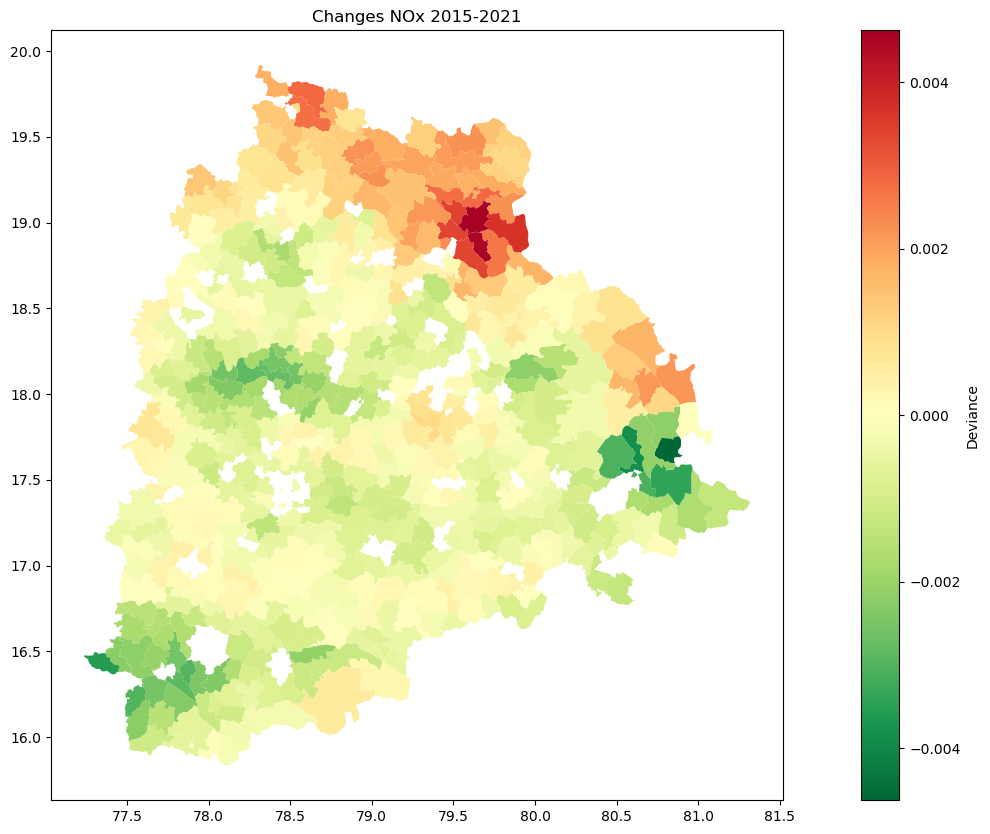

In [47]:
#We will loop over all boundaries and calculate it's deviant score
ids= []
scores = []

for i in NOx_df.columns[1:-1]:
    ids.append(i)
    #We use the previously defined function in order to calculate the trend score per specific area
    score = Trend_Score(NOx_df, i)
    scores.append(score)

#Create a Dataframe from the scores
DPPD_df = pd.DataFrame({'index': ids, 'Slope Score': scores}) 

#Only select the regions that do not have unknown scores
DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']

DPPD_df['index'] = DPPD_df['index'].astype(int)

#We merge the dataframe with the boundaries dataframe such that we have the geometry variable
DPPD_df = DPPD_df.merge(mandal_boundaries[['index', 'geometry']], how='left', on=['index'])

#Making sure data has the right type
DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')

#Define text for the plots
text = 'Changes NOx 2015-2021'
ranges = max(abs(DPPD_df['Slope Score'].min()), (DPPD_df['Slope Score'].max()))
vmin, vmax, vcenter = ranges*-1 , ranges, 0
norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) 
# create a normalized colorbar
cmap = 'RdYlGn_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
DPPD_df.plot(column = 'Slope Score', 
                    legend = True, 
                    figsize = [20,10],\
                    legend_kwds = {'label': 'Deviance'}, 
                    cmap = 'RdYlGn_r',
                    norm = norm)
plt.title(text)
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\NOx\\result')
plt.savefig(text + '.png', bbox_inches='tight')
plt.show()

In [48]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Fires\\results')
DPPD_Fires = pd.read_csv('DPPD_Fires_2021.csv', index_col = 0)
DPPD_Fires.columns = ['index', 'Slope Score Fires', 'geometry']

In [49]:
Corr = DPPD_Fires.merge(DPPD_df[['Slope Score', 'index']], how = 'left', on = ['index'])

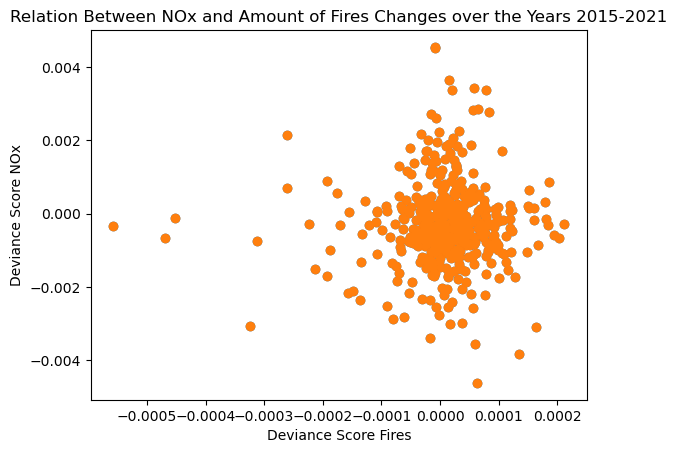

In [52]:
plt.scatter(Corr['Slope Score Fires'], Corr['Slope Score'])
plt.title('Relation Between NOx and Amount of Fires Changes over the Years 2015-2021')
plt.xlabel('Deviance Score Fires')
plt.ylabel('Deviance Score NOx')
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\NOx\\result')
plt.savefig('Relation between NOx and Fires Changes.png', bbox_inches='tight')
plt.show()